In [2]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_pickle("merged_training.pkl")
df.head()

Saving merged_training.pkl to merged_training.pkl


,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [4]:
#Original Dataset has like 400k+ records, my computer would die if I wanted to run models on it, so much smaller dataset for this :/
df_sample = df.sample(n=3000, random_state=42)
df_sample.describe()

,text,emotions
count,3000,3000
unique,3000,6
top,i feel anxious about being good enough,joy
freq,1,1032


In [5]:
df_sample.head()

,text,emotions
28440,i just feel really helpless and heavy hearted,fear
120222,ive enjoyed being able to slouch about relax a...,sadness
24397,i gave up my internship with the dmrg and am f...,fear
22002,i dont know i feel so lost,sadness
212,i am a kindergarten teacher and i am thoroughl...,fear


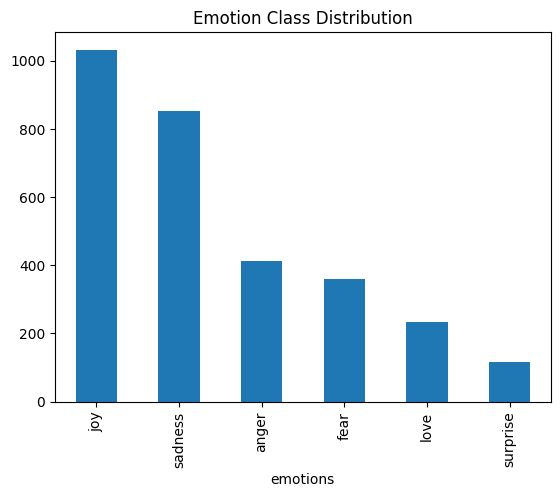

In [6]:
import matplotlib.pyplot as plt

df_sample["emotions"].value_counts().plot(kind="bar", title="Emotion Class Distribution")
plt.show()

In [7]:
def map_emotion_to_label(emotion):
    if emotion in ["joy", "love", "surprise"]:
        return ("Nuetral")  # 1,2,3
    elif emotion == "sadness":
        return ("Mild Distress")  # 4
    else:
        return ("High Risk")  # 5

df_sample["custom_label"] = df_sample["emotions"].apply(map_emotion_to_label)

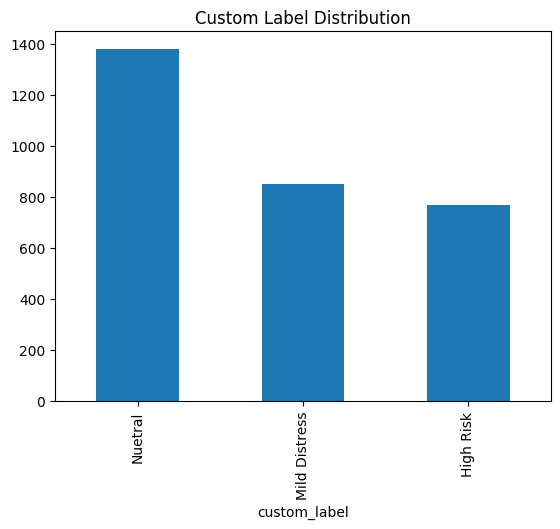

In [8]:
df_sample["custom_label"].value_counts().plot(kind="bar", title="Custom Label Distribution")
plt.show()

In [37]:
label_map = {
    "joy": 0,
    "love": 0,
    "surprise": 0,
    "sadness": 1,
    "fear": 2,
    "anger": 2
}

#Apply mapping
df_sample["custom_label"] = df_sample["emotions"].map(label_map)
print(df_sample["custom_label"].unique())

[2 1 0]


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_sample["text"], df_sample["custom_label"],
    test_size=0.2,
    stratify=df_sample["custom_label"],
    random_state=42
)

In [39]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)

In [40]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = [int(label) for label in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)

In [41]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

#I wanted to use different args but my computational limitations only allowed for these as a safe bet ;/
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
trainer.train()

Step,Training Loss
10,1.096000
20,1.067700
30,1.054500
40,1.153400
50,1.026000
60,0.850600
70,0.793500
80,0.893400
90,0.559500
100,0.748600


TrainOutput(global_step=600, training_loss=0.5280915828049183, metrics={'train_runtime': 1320.2265, 'train_samples_per_second': 1.818, 'train_steps_per_second': 0.454, 'total_flos': 43466640336000.0, 'train_loss': 0.5280915828049183, 'epoch': 1.0})

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [44]:
eval_result = trainer.evaluate()
print("Raw Eval Result:", eval_result)

Raw Eval Result: {'eval_loss': 0.3519584536552429, 'eval_runtime': 70.3839, 'eval_samples_per_second': 8.525, 'eval_steps_per_second': 2.131, 'epoch': 1.0}


In [45]:
predictions = trainer.predict(val_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)


In [47]:
print(classification_report(y_val, y_pred, target_names=["Neutral", "Mild Distress", "High Risk"]))


               precision    recall  f1-score   support

      Neutral       0.95      0.94      0.94       276
Mild Distress       0.92      0.88      0.90       170
    High Risk       0.86      0.91      0.88       154

     accuracy                           0.92       600
    macro avg       0.91      0.91      0.91       600
 weighted avg       0.92      0.92      0.92       600



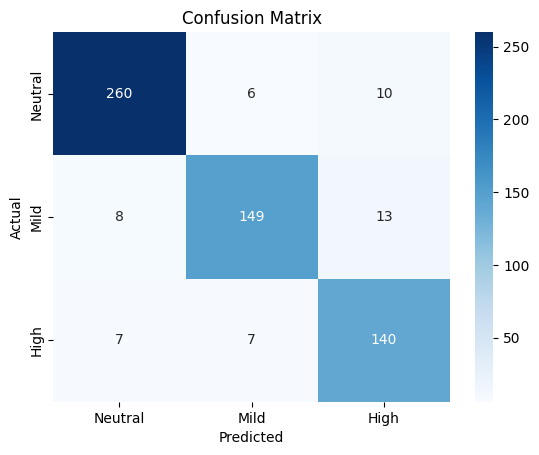

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Mild", "High"], yticklabels=["Neutral", "Mild", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
report = classification_report(
    y_val, y_pred,
    target_names=["Neutral", "Mild Distress", "High Risk"],
    output_dict=True
)
import pandas as pd
report_df = pd.DataFrame(report).transpose()
print("🔍 Classification Report:")
display(report_df.round(2))

🔍 Classification Report:


,precision,recall,f1-score,support
Neutral,0.95,0.94,0.94,276.00
Mild Distress,0.92,0.88,0.90,170.00
High Risk,0.86,0.91,0.88,154.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.91,0.91,0.91,600.00
weighted avg,0.92,0.92,0.92,600.00
